In [1]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [5]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

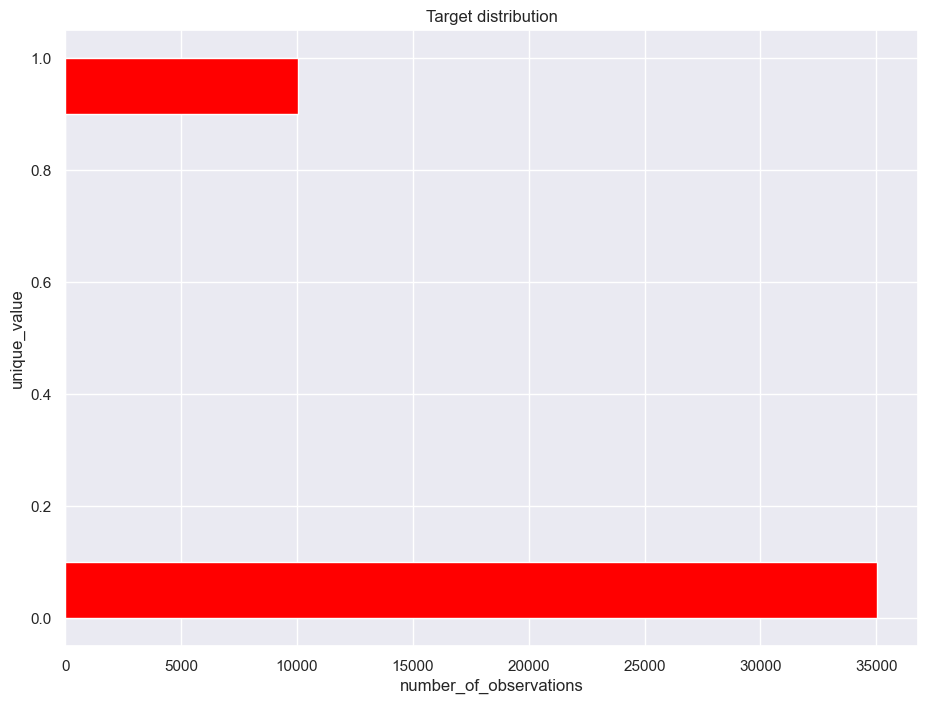

In [7]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [8]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [9]:
table = fill_nan(data)

In [10]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [11]:
np.random.seed(0)

In [12]:
np.random.randint?

Docstring:
randint(low, high=None, size=None, dtype=int)

Return random integers from `low` (inclusive) to `high` (exclusive).

Return random integers from the "discrete uniform" distribution of
the specified dtype in the "half-open" interval [`low`, `high`). If
`high` is None (the default), then results are from [0, `low`).

.. note::
    New code should use the `~numpy.random.Generator.integers`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
low : int or array-like of ints
    Lowest (signed) integers to be drawn from the distribution (unless
    ``high=None``, in which case this parameter is one above the
    *highest* such integer).
high : int or array-like of ints, optional
    If provided, one above the largest (signed) integer to be drawn
    from the distribution (see above for behavior if ``high=None``).
    If array-like, must contain integer values
size : int or tuple of ints, optional
    Outp

In [13]:
def get_boostrap_samples(data, nsamples):
    indexes = np.random.randint(0, len(data), (nsamples, len(data)))
    boostrap_sample = data[indexes]
    return boostrap_sample

def get_intervals(stat, alpha):
    return np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

mean_age = [np.mean(bt) for bt in get_boostrap_samples(table[table['SeriousDlqin2yrs'] == 1]['age'].values, int((table.shape[0])**0.5))]
get_intervals(mean_age, 0.1)


array([45.7212697 , 46.12459106])

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [15]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [16]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [18]:
grid = GridSearchCV(estimator=lr, param_grid= parameters,cv=skf, n_jobs=-1, scoring= 'roc_auc')

In [19]:
grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [20]:
grid.cv_results_["std_test_score"][1]

0.00771636304986469

In [21]:
grid.best_score_

0.7947374907656825

In [24]:
from scipy.special import softmax

In [22]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723421
3,NumberOfTimes90DaysLate,0.516656
4,NumberOfTime60-89DaysPastDueNotWorse,0.195486
6,NumberOfDependents,0.101722
2,DebtRatio,-0.024068
5,MonthlyIncome,-0.163015
0,age,-0.417115


In [26]:
pd.DataFrame({'feat': independent_columns_names, 'softmax': softmax(lr.coef_).flatten().tolist()})

,feat,softmax
0,age,0.077109
1,NumberOfTime30-59DaysPastDueNotWorse,0.241232
2,DebtRatio,0.114236
3,NumberOfTimes90DaysLate,0.196172
4,NumberOfTime60-89DaysPastDueNotWorse,0.142284
5,MonthlyIncome,0.099417
6,NumberOfDependents,0.129549


In [28]:
lr_unscaled = LogisticRegression(random_state=5, class_weight="balanced", n_jobs=-1)

In [30]:
lr_unscaled.fit(X, y)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=5)

In [36]:
cust = X.iloc[0, :]
cust_20 = pd.Series(cust, copy=True)
cust_20['age']+=20

cust_20

age                                       84.000000
NumberOfTime30-59DaysPastDueNotWorse       0.000000
DebtRatio                                  0.249908
NumberOfTimes90DaysLate                    0.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
MonthlyIncome                           8158.000000
NumberOfDependents                         0.000000
Name: 0, dtype: float64

In [38]:
cust

age                                       64.000000
NumberOfTime30-59DaysPastDueNotWorse       0.000000
DebtRatio                                  0.249908
NumberOfTimes90DaysLate                    0.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
MonthlyIncome                           8158.000000
NumberOfDependents                         0.000000
Name: 0, dtype: float64

In [40]:
print('Normal age:' , str(lr_unscaled.predict_proba(cust.values.reshape(1,-1))), '\n',
      'Age + 20:', str(lr_unscaled.predict_proba(cust_20.values.reshape(1,-1))) ,'\n' ,
      'Times changed:', str(lr_unscaled.predict_proba(cust_20.values.reshape(1,-1))/lr_unscaled.predict_proba(cust.values.reshape(1,-1))))

Normal age: [[0.71470561 0.28529439]] 
 Age + 20: [[0.77540692 0.22459308]] 
 Times changed: [[1.0849319  0.78723275]]


In [42]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [46]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [48]:
grid = GridSearchCV(estimator=rf, param_grid= parameters,cv=skf, n_jobs=-1, scoring= 'roc_auc')

In [50]:
grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [54]:
grid.best_score_ -0.7947374907656825

0.04104104722065982

In [62]:
pd.DataFrame({'col_name':independent_columns_names, 'coef': grid.best_estimator_.feature_importances_}).sort_values(by="coef", ascending=False)

,col_name,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
0,age,0.115860
2,DebtRatio,0.076082
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


In [90]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [92]:
bg = BaggingClassifier(
    LogisticRegression(class_weight="balanced"),
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True,
)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


ValueError: Invalid parameter 'base_estimator' for estimator BaggingClassifier(estimator=LogisticRegression(class_weight='balanced'),
                  max_features=3, max_samples=0.5, n_estimators=100, n_jobs=-1,
                  random_state=42). Valid parameters are: ['bootstrap', 'bootstrap_features', 'estimator', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].